In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline
import os
from scipy.stats import gaussian_kde
import metpy.calc as mpcalc
from metpy.units import units

In [2]:
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  file_dir = "F:/github/pythonScript/seafog/"
else:
  file_dir = "H:/github/python/seafog/"

In [3]:
file_59754 = os.path.normpath(os.path.join(file_dir, './data/station/59754.20130101-2022093023.csv'))
df_59754 = pd.read_csv(file_59754,sep=',',na_values=[9999])
df_59754.index = pd.to_datetime(df_59754["DDATETIME"])

df_code = pd.read_csv(os.path.normpath(os.path.join(file_dir, './code_readme.csv')),sep=',')

C:\Users\Henry\AppData\Local\Temp\ipykernel_3912\2792315665.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_59754 = pd.read_csv(file_59754,sep=',',na_values=[9999])


In [4]:
print(df_59754.columns)

Index(['DDATETIME', 'V01301', 'D_RYMDHM', 'D_IYMDHM', 'V04001', 'V04002',
       'V04003', 'V04004', 'V04005', 'V05001',
       ...
       'V13925', 'V13930', 'V13935', 'V13940', 'V13945', 'V13950', 'V13955',
       'V13960', 'FLAG_ELEMENTS', 'FLAG_RAIN'],
      dtype='object', length=129)


In [5]:
code_info = {
  'vis01':'V20059',
  'vis_01min':'V20001_701_01',
  'vis_10min':'V20001_701_10',
  'vis':'V20001',
  'td': 'V12003',
  't2m': 'V12001',
  "year":"V04001",
  "month": "V04002",
  "day": "V04003",
  "hour":"V04004",
  "minute":"V04005",
  "rhum":"V13003",
  'rain01':'V13019',
}

In [6]:
# 筛选雾出现的行

df_fog = df_59754.loc[df_59754[code_info['vis_01min']]<=1000]
df_fog = df_fog.loc[df_fog[code_info['rain01']] < 1].loc[df_fog[code_info['rhum']] > 80]
print(df_fog)


                                 DDATETIME  V01301               D_RYMDHM  \
DDATETIME                                                                   
2013-02-01 19:00:00  2013-02-01 19:00:00.0   59754  2013-02-03 00:20:15.0   
2013-02-01 20:00:00  2013-02-01 20:00:00.0   59754  2013-02-03 00:20:20.0   
2013-02-01 23:00:00  2013-02-01 23:00:00.0   59754  2013-02-01 23:08:41.0   
2013-02-03 15:00:00  2013-02-03 15:00:00.0   59754  2013-02-03 15:06:56.0   
2013-02-03 16:00:00  2013-02-03 16:00:00.0   59754  2013-02-03 16:05:45.0   
...                                    ...     ...                    ...   
2022-03-13 21:00:00  2022-03-13 21:00:00.0   59754  2022-08-20 06:44:33.0   
2022-03-14 23:00:00  2022-03-14 23:00:00.0   59754  2022-08-20 07:11:30.0   
2022-03-15 00:00:00  2022-03-15 00:00:00.0   59754  2022-08-20 07:12:30.0   
2022-03-16 21:00:00  2022-03-16 21:00:00.0   59754  2022-08-20 08:03:30.0   
2022-04-21 22:00:00  2022-04-21 22:00:00.0   59754  2022-08-20 19:42:00.0   

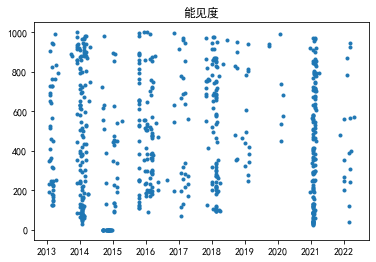

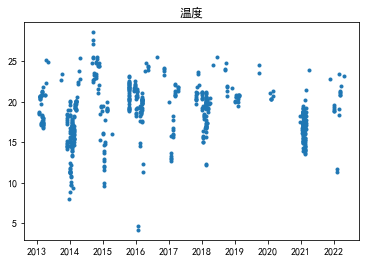

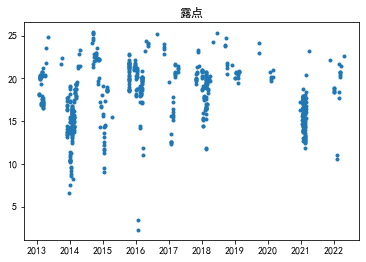

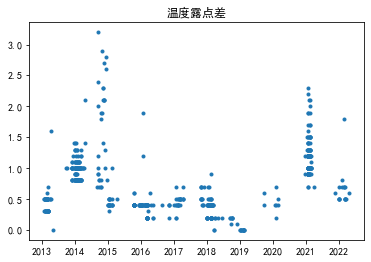

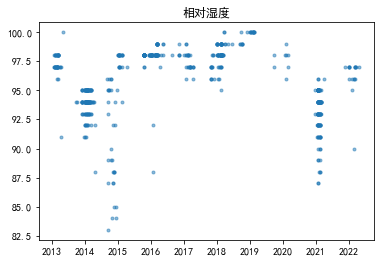

In [7]:
plt.plot(df_fog.index, df_fog[code_info['vis_01min']], '.')
plt.title('能见度')
plt.show()
plt.plot(df_fog.index, df_fog[code_info['t2m']], '.')
plt.title('温度')
plt.show()
plt.plot(df_fog.index, df_fog[code_info['td']], '.')
plt.title('露点')
plt.show()
plt.plot(df_fog.index, df_fog[code_info['t2m']]-df_fog[code_info['td']], '.')
plt.title('温度露点差')
plt.show()
plt.plot(df_fog.index, df_fog[code_info['rhum']], '.', alpha=0.5)
plt.title('相对湿度')
plt.show()

<AxesSubplot:title={'center':'雾频次月份统计'}>

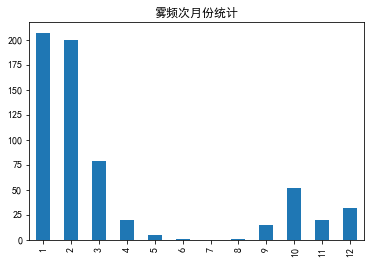

In [8]:
month_count = df_fog[code_info["month"]].value_counts().sort_index()
# print(month_count)
for index in range(12):
    month = index + 1
    if(month not in month_count.index):
      month_count.loc[month] = 0
month_count = month_count.sort_index()
month_count.plot.bar(title='雾频次月份统计')

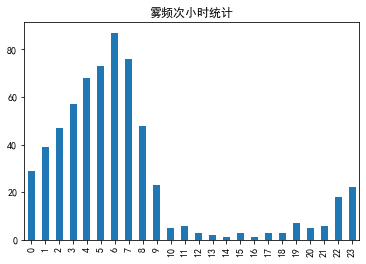

In [9]:
hour_count = df_fog[code_info["hour"]].value_counts().sort_index()
# hour_count.plot.bar()
# plt.show()
BJ_hour_count = pd.Series(np.arange(0,24))
for index in range(len(BJ_hour_count)):
    utc_index = index - 8 if index - 8>=0 else index - 8 +24
    BJ_hour_count[index] = hour_count.loc[utc_index] if utc_index in hour_count.index else 0

BJ_hour_count.plot.bar(title='雾频次小时统计')
plt.show()

<AxesSubplot:title={'center':'雾频次日历日统计'}>

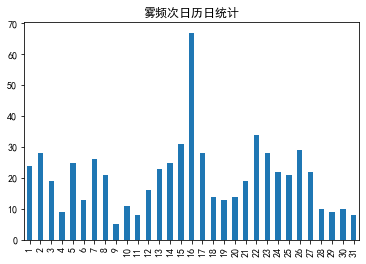

In [10]:
day_count = df_fog[code_info["day"]].value_counts().sort_index()
for index in range(31):
    day = index + 1
    if(day not in day_count.index):
      day_count.loc[day] = 0
day_count = day_count.sort_index()
day_count.plot.bar(title='雾频次日历日统计')

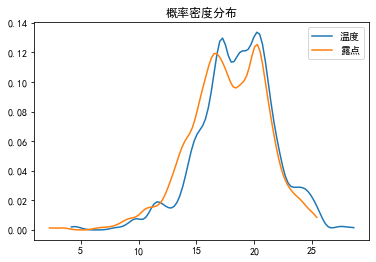

In [11]:
# 高斯分布概率密度函数
t2m = df_fog[code_info['t2m']]
eval_points = np.linspace(np.min(t2m), np.max(t2m), num = 100)
kde_sp = gaussian_kde(t2m, bw_method=0.15)
y_sp = kde_sp.pdf(eval_points)
plt.plot(eval_points, y_sp)


data_raw = df_fog[code_info['td']]
eval_points = np.linspace(np.min(data_raw), np.max(data_raw), num = 100)
kde_sp = gaussian_kde(data_raw, bw_method=0.15)
y_sp = kde_sp.pdf(eval_points)
plt.plot(eval_points, y_sp)
plt.title('概率密度分布')
plt.legend(['温度','露点'])
plt.show()

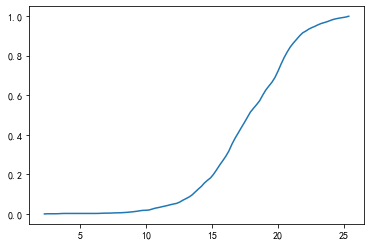

In [12]:
from scipy.special import ndtr
cdf = tuple(ndtr(np.ravel(item - kde_sp.dataset) / kde_sp.factor).mean()
                for item in eval_points)
plt.plot(eval_points, cdf)

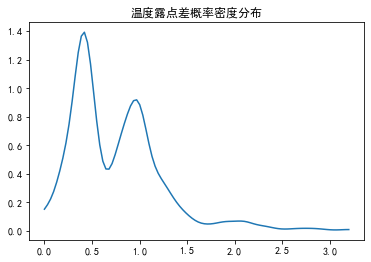

In [13]:
data_raw = df_fog[code_info['t2m']] - df_fog[code_info['td']]
eval_points = np.linspace(np.min(data_raw), np.max(data_raw), num = 100)
kde_sp = gaussian_kde(data_raw, bw_method=0.2)
y_sp = kde_sp.pdf(eval_points)
plt.plot(eval_points, y_sp)
plt.title('温度露点差概率密度分布')
plt.show()

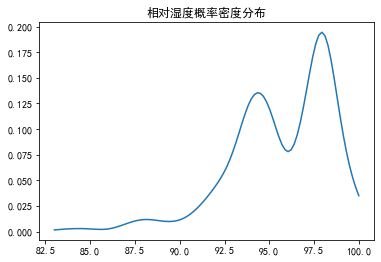

In [14]:
data_raw = df_fog[code_info['rhum']]
eval_points = np.linspace(np.min(data_raw), np.max(data_raw), num = 100)
kde_sp = gaussian_kde(data_raw, bw_method=0.25)
y_sp = kde_sp.pdf(eval_points)
plt.plot(eval_points, y_sp)
plt.title('相对湿度概率密度分布')
plt.show()

In [15]:
ds_G7425 = pd.read_hdf(os.path.normpath(os.path.join(file_dir, './data/G7425/G7425_202012to202209.hdf')), mode='r')

In [16]:
df_fog.index

DatetimeIndex(['2013-02-01 19:00:00', '2013-02-01 20:00:00',
               '2013-02-01 23:00:00', '2013-02-03 15:00:00',
               '2013-02-03 16:00:00', '2013-02-03 18:00:00',
               '2013-02-03 19:00:00', '2013-02-03 20:00:00',
               '2013-02-03 21:00:00', '2013-02-05 16:00:00',
               ...
               '2022-03-01 18:00:00', '2022-03-02 01:00:00',
               '2022-03-04 03:00:00', '2022-03-13 19:00:00',
               '2022-03-13 20:00:00', '2022-03-13 21:00:00',
               '2022-03-14 23:00:00', '2022-03-15 00:00:00',
               '2022-03-16 21:00:00', '2022-04-21 22:00:00'],
              dtype='datetime64[ns]', name='DDATETIME', length=632, freq=None)

In [17]:
ds_G7425.index

DatetimeIndex(['2020-12-23 00:00:00', '2020-12-23 00:10:00',
               '2020-12-23 00:20:00', '2020-12-23 00:30:00',
               '2020-12-23 00:40:00', '2020-12-23 00:50:00',
               '2020-12-23 01:00:00', '2020-12-23 01:10:00',
               '2020-12-23 01:20:00', '2020-12-23 01:30:00',
               ...
               '2022-09-28 12:10:00', '2022-09-28 12:20:00',
               '2022-09-28 12:30:00', '2022-09-28 12:40:00',
               '2022-09-28 12:50:00', '2022-09-28 13:00:00',
               '2022-09-28 13:10:00', '2022-09-28 13:20:00',
               '2022-09-28 13:30:00', '2022-09-28 13:40:00'],
              dtype='datetime64[ns]', name='date', length=67520, freq=None)

In [18]:
bjtime_index = df_fog.index.to_series() + pd.Timedelta(8,unit='h')

In [19]:
inter_index = ds_G7425.index.intersection(bjtime_index)
utc_inter_index = inter_index.to_series() + pd.Timedelta(-8,unit='h')
df_fog_inter = df_fog.loc[utc_inter_index]

In [20]:
print(inter_index)

DatetimeIndex(['2020-12-28 03:00:00', '2020-12-28 07:00:00',
               '2021-01-16 01:00:00', '2021-01-16 02:00:00',
               '2021-01-16 03:00:00', '2021-01-22 11:00:00',
               '2021-01-22 12:00:00', '2021-01-22 13:00:00',
               '2021-01-22 19:00:00', '2021-01-22 20:00:00',
               ...
               '2022-02-01 09:00:00', '2022-03-02 02:00:00',
               '2022-03-02 09:00:00', '2022-03-04 11:00:00',
               '2022-03-14 04:00:00', '2022-03-14 05:00:00',
               '2022-03-15 07:00:00', '2022-03-15 08:00:00',
               '2022-03-17 05:00:00', '2022-04-22 06:00:00'],
              dtype='datetime64[ns]', name='date', length=143, freq=None)


In [21]:
ds_G7425_fogFilter = ds_G7425.loc[inter_index].dropna(subset=['SeaTemperature', 'RelativeHumidity','Temperature'])
print(ds_G7425_fogFilter)

                            ObserveTime  WindSpeed  WindDirect  Rain  \
date                                                                   
2020-12-28 03:00:00 2020-12-28 03:00:00        2.7        97.0   0.0   
2020-12-28 07:00:00 2020-12-28 07:00:00        3.4        68.0   0.0   
2021-01-16 01:00:00 2021-01-16 01:00:00        1.1        41.0   0.0   
2021-01-16 02:00:00 2021-01-16 02:00:00        0.9        44.0   0.0   
2021-01-16 03:00:00 2021-01-16 03:00:00        1.7        69.0   0.0   
...                                 ...        ...         ...   ...   
2022-03-14 05:00:00 2022-03-14 05:00:00        3.1        74.0   0.0   
2022-03-15 07:00:00 2022-03-15 07:00:00        1.8        74.0   0.0   
2022-03-15 08:00:00 2022-03-15 08:00:00        2.0        87.0   0.0   
2022-03-17 05:00:00 2022-03-17 05:00:00        3.0        56.0   0.0   
2022-04-22 06:00:00 2022-04-22 06:00:00        4.0        87.0   0.0   

                     MaxWindSpeed  MaxWindDirect  Temperature  

<AxesSubplot:xlabel='date'>

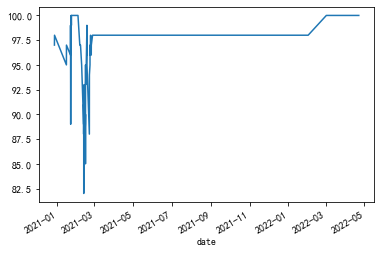

In [22]:
ds_G7425_fogFilter['RelativeHumidity'].plot()

In [23]:
rhum = ds_G7425_fogFilter['RelativeHumidity'].values*units.percent
temp = ds_G7425_fogFilter['Temperature'].values*units.degC
td = mpcalc.dewpoint_from_relative_humidity(temp, rhum)
ds_G7425_fogFilter['Dewpoint'] = td

In [24]:
ds_G7425_fogFilter['t-td'] = ds_G7425_fogFilter['Temperature'] - ds_G7425_fogFilter['Dewpoint']
ds_G7425_fogFilter['td-sst'] = ds_G7425_fogFilter['Dewpoint'] - ds_G7425_fogFilter['SeaTemperature']
ds_G7425_fogFilter['t-sst'] = ds_G7425_fogFilter['Temperature'] - ds_G7425_fogFilter['SeaTemperature']


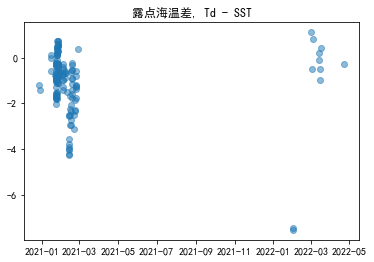

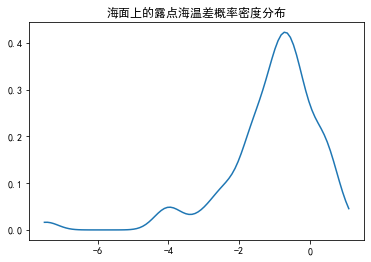

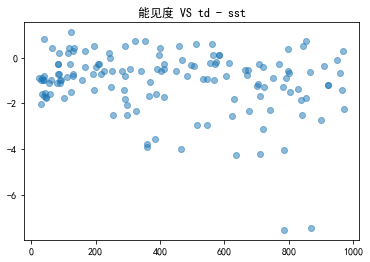

In [25]:
plt.scatter(ds_G7425_fogFilter.index, ds_G7425_fogFilter['td-sst'], marker='o',  alpha=0.5)
plt.title('露点海温差, Td - SST')
plt.show()

data_raw = ds_G7425_fogFilter['td-sst']
eval_points = np.linspace(np.min(data_raw), np.max(data_raw), num = 100)
kde_sp = gaussian_kde(data_raw, bw_method=0.25)
y_sp = kde_sp.pdf(eval_points)
plt.plot(eval_points, y_sp)
plt.title('海面上的露点海温差概率密度分布')
plt.show()

plt.scatter(df_fog_inter[code_info['vis_01min']], ds_G7425_fogFilter['td-sst'], marker='o',  alpha=0.5)
plt.title('能见度 VS td - sst')
plt.show()

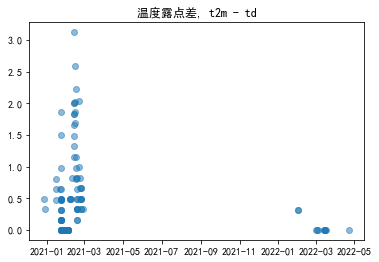

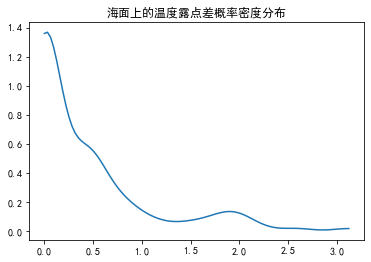

In [26]:
plt.scatter(ds_G7425_fogFilter.index, ds_G7425_fogFilter['t-td'], marker='o',  alpha=0.5)
plt.title('温度露点差, t2m - td')
plt.show()

data_raw = ds_G7425_fogFilter['t-td']
eval_points = np.linspace(np.min(data_raw), np.max(data_raw), num = 100)
kde_sp = gaussian_kde(data_raw, bw_method=0.25)
y_sp = kde_sp.pdf(eval_points)
plt.plot(eval_points, y_sp)
plt.title('海面上的温度露点差概率密度分布')
plt.show()

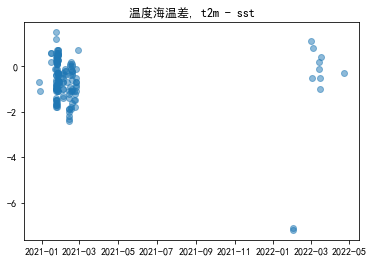

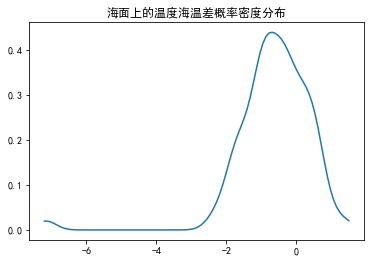

In [27]:
# 温度海温差
plt.scatter(ds_G7425_fogFilter.index, ds_G7425_fogFilter['t-sst'], marker='o',  alpha=0.5)
plt.title('温度海温差, t2m - sst')
plt.show()

data_raw = ds_G7425_fogFilter['t-sst']
eval_points = np.linspace(np.min(data_raw), np.max(data_raw), num = 100)
kde_sp = gaussian_kde(data_raw, bw_method=0.25)
y_sp = kde_sp.pdf(eval_points)
plt.plot(eval_points, y_sp)
plt.title('海面上的温度海温差概率密度分布')
plt.show()

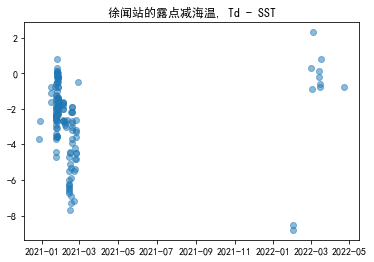

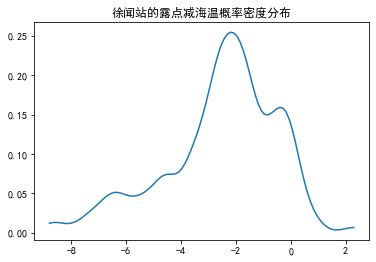

In [28]:
xuwen_td_sst = df_fog_inter[code_info['td']].values - ds_G7425_fogFilter['SeaTemperature'].values
plt.scatter(ds_G7425_fogFilter.index, xuwen_td_sst, marker='o',  alpha=0.5)
plt.title('徐闻站的露点减海温, Td - SST')
plt.show()

data_raw = xuwen_td_sst
eval_points = np.linspace(np.min(data_raw), np.max(data_raw), num = 100)
kde_sp = gaussian_kde(data_raw, bw_method=0.2)
y_sp = kde_sp.pdf(eval_points)
plt.plot(eval_points, y_sp)
plt.title('徐闻站的露点减海温概率密度分布')
plt.show()

<AxesSubplot:xlabel='date'>

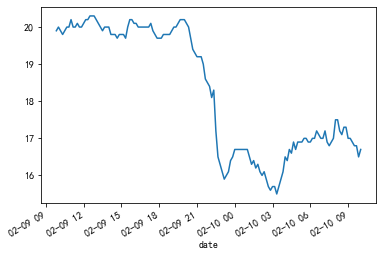

In [29]:
ds_G7425[144*47:144*48]['Temperature'].plot()